<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 19 06:30:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   30C    P0    28W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(convert_color, original=False, preprocess=False):
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.resnet50.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.resnet50.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 23s 44ms/step - loss: 0.6415 - accuracy: 0.7421 - val_loss: 0.4590 - val_accuracy: 0.8086
Epoch 2/100
360/360 [==============================] - 14s 40ms/step - loss: 0.4901 - accuracy: 0.7912 - val_loss: 0.4296 - val_accuracy: 0.8192
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4547 - accuracy: 0.8080 - val_loss: 0.3890 - val_accuracy: 0.8352
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4282 - accuracy: 0.8217 - val_loss: 0.3888 - val_accuracy: 0.8336
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4150 - accuracy: 0.8290 - val_loss: 0.3692 - val_accuracy: 0.8493
Epoch 6/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4007 -

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2896 - accuracy: 0.8837 - val_loss: 0.3260 - val_accuracy: 0.8736
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2808 - accuracy: 0.8874 - val_loss: 0.3303 - val_accuracy: 0.8725
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2832 - accuracy: 0.8863 - val_loss: 0.2979 - val_accuracy: 0.8784
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2802 - accuracy: 0.8874 - val_loss: 0.2992 - val_accuracy: 0.8850
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2785 - accuracy: 0.8875 - val_loss: 0.3133 - val_accuracy: 0.8807
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2760 - accuracy: 0.8889 - val_loss: 0.2976 - val_accuracy: 0.8816
Epoch 62/100
360/360 [==============================] - 12s 35ms/step - loss: 0.2762 - accuracy: 0.8894 - val_loss: 0.2936 -

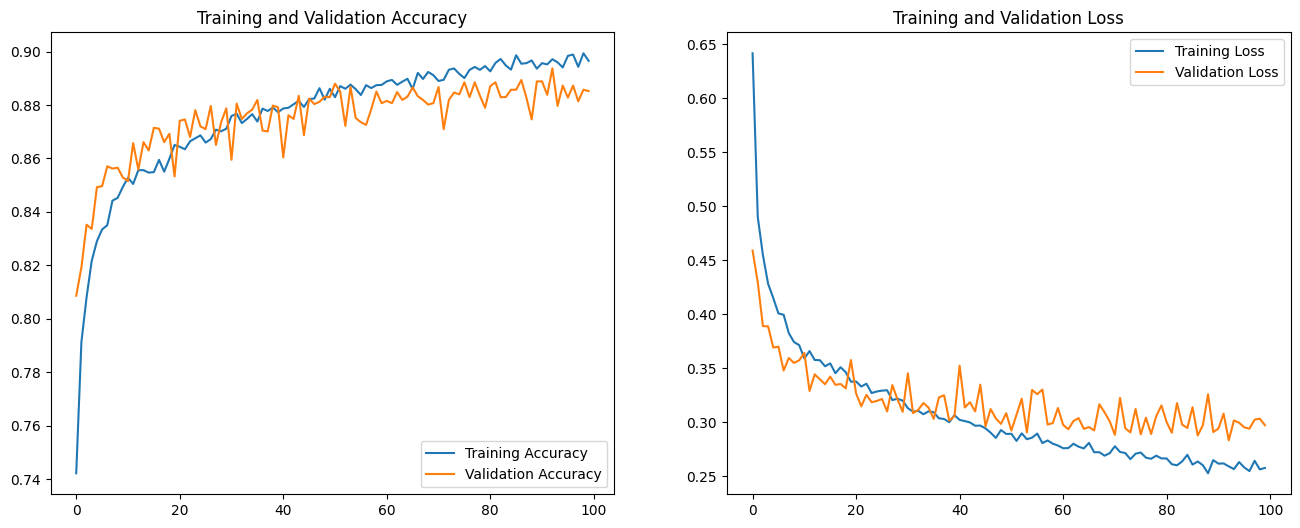

In [5]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 39ms/step - loss: 0.7126 - accuracy: 0.7088 - val_loss: 0.5352 - val_accuracy: 0.7735
Epoch 2/100
360/360 [==============================] - 14s 40ms/step - loss: 0.5559 - accuracy: 0.7609 - val_loss: 0.5235 - val_accuracy: 0.7654
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5319 - accuracy: 0.7742 - val_loss: 0.4779 - val_accuracy: 0.8029
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5162 - accuracy: 0.7857 - val_loss: 0.5099 - val_accuracy: 0.7805
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5030 - accuracy: 0.7885 - val_loss: 0.4764 - val_accuracy: 0.8027
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3634 - accuracy: 0.8504 - val_loss: 0.3609 - val_accuracy: 0.8555
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3614 - accuracy: 0.8534 - val_loss: 0.3687 - val_accuracy: 0.8548
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3638 - accuracy: 0.8532 - val_loss: 0.3568 - val_accuracy: 0.8571
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3540 - accuracy: 0.8572 - val_loss: 0.3585 - val_accuracy: 0.8567
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3614 - accuracy: 0.8544 - val_loss: 0.3663 - val_accuracy: 0.8560
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3609 - accuracy: 0.8548 - val_loss: 0.3685 - val_accuracy: 0.8550
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3619 - accuracy: 0.8542 - val_loss: 0.3779 -

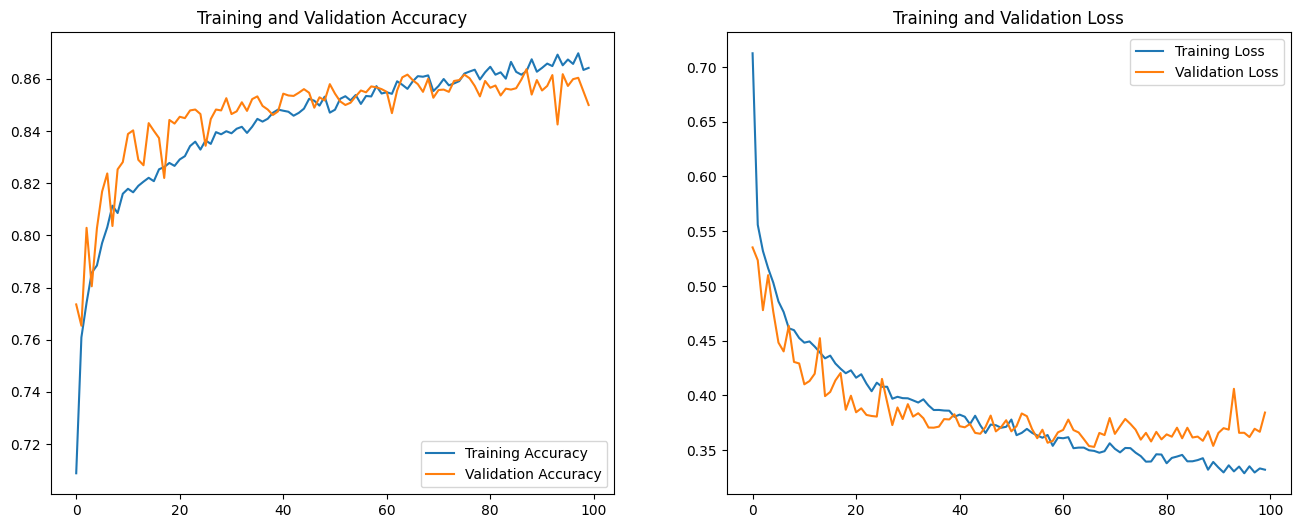

In [6]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 18s 39ms/step - loss: 0.9240 - accuracy: 0.6710 - val_loss: 0.5794 - val_accuracy: 0.7503
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6251 - accuracy: 0.7354 - val_loss: 0.5593 - val_accuracy: 0.7567
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6026 - accuracy: 0.7463 - val_loss: 0.5297 - val_accuracy: 0.7777
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5801 - accuracy: 0.7554 - val_loss: 0.5160 - val_accuracy: 0.7834
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5577 - accuracy: 0.7684 - val_loss: 0.5310 - val_accuracy: 0.7782
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5439 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4096 - accuracy: 0.8353 - val_loss: 0.4230 - val_accuracy: 0.8338
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4060 - accuracy: 0.8380 - val_loss: 0.4211 - val_accuracy: 0.8350
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4062 - accuracy: 0.8351 - val_loss: 0.4203 - val_accuracy: 0.8361
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4016 - accuracy: 0.8388 - val_loss: 0.4365 - val_accuracy: 0.8272
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4077 - accuracy: 0.8359 - val_loss: 0.4165 - val_accuracy: 0.8367
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4015 - accuracy: 0.8379 - val_loss: 0.4412 - val_accuracy: 0.8235
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4031 - accuracy: 0.8392 - val_loss: 0.4208 -

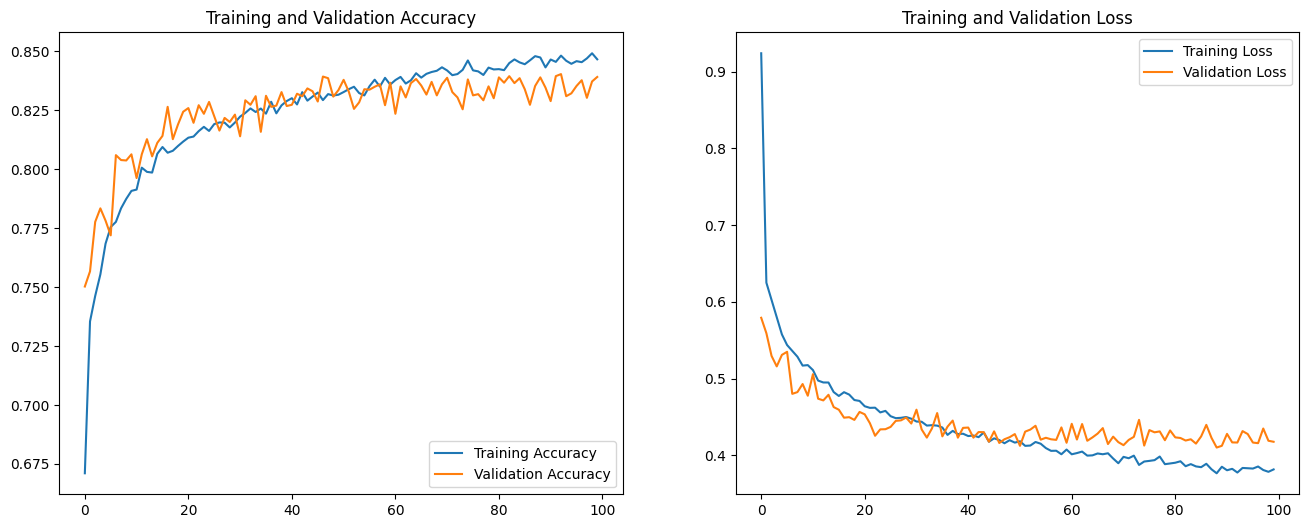

In [7]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 39ms/step - loss: 1.4526 - accuracy: 0.2848 - val_loss: 1.4115 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4292 - accuracy: 0.2878 - val_loss: 1.4149 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4258 - accuracy: 0.2875 - val_loss: 1.4115 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4247 - accuracy: 0.2913 - val_loss: 1.4142 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4238 - accuracy: 0.2947 - val_loss: 1.4114 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3723 - accuracy: 0.3713 - val_loss: 1.3444 - val_accuracy: 0.3989
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3731 - accuracy: 0.3717 - val_loss: 1.3360 - val_accuracy: 0.4097
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3706 - accuracy: 0.3743 - val_loss: 1.3157 - val_accuracy: 0.4340
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3713 - accuracy: 0.3713 - val_loss: 1.3212 - val_accuracy: 0.4232
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3706 - accuracy: 0.3723 - val_loss: 1.3251 - val_accuracy: 0.4208
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3696 - accuracy: 0.3746 - val_loss: 1.3195 - val_accuracy: 0.4248
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3707 - accuracy: 0.3709 - val_loss: 1.3235 -

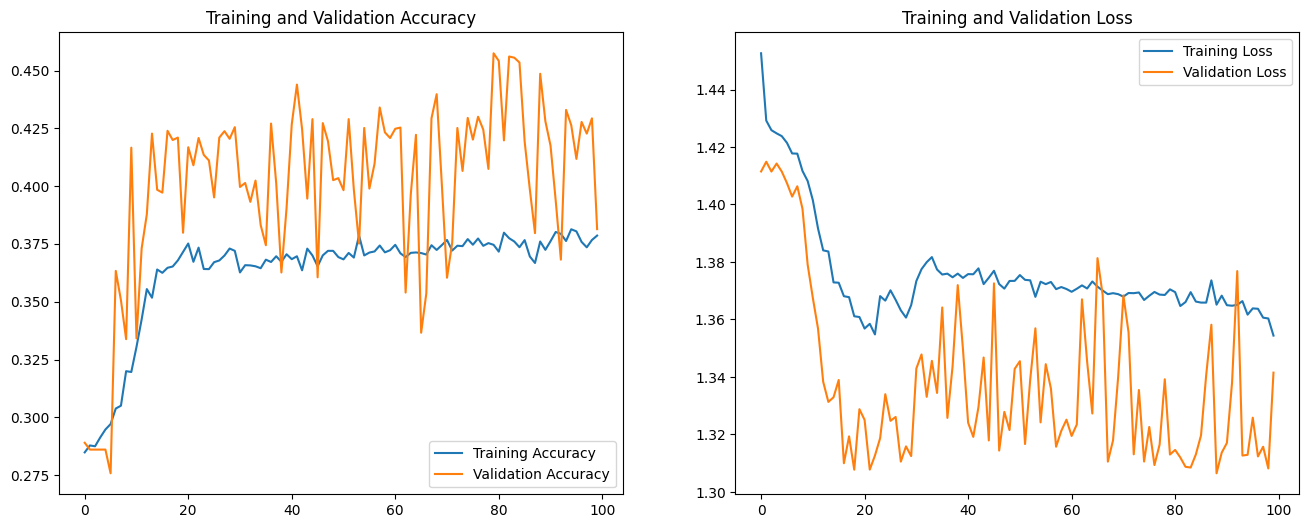

In [8]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 19s 40ms/step - loss: 1.4456 - accuracy: 0.2835 - val_loss: 1.4294 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4264 - accuracy: 0.2928 - val_loss: 1.4188 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4219 - accuracy: 0.2994 - val_loss: 1.4040 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4117 - accuracy: 0.3222 - val_loss: 1.4025 - val_accuracy: 0.2866
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4031 - accuracy: 0.3353 - val_loss: 1.3715 - val_accuracy: 0.4152
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.3926 - accuracy: 0.3

Epoch 56/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2955 - accuracy: 0.4233 - val_loss: 1.2297 - val_accuracy: 0.4585
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2899 - accuracy: 0.4229 - val_loss: 1.2381 - val_accuracy: 0.4340
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2912 - accuracy: 0.4269 - val_loss: 1.2447 - val_accuracy: 0.4436
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3053 - accuracy: 0.4160 - val_loss: 1.2270 - val_accuracy: 0.4554
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2978 - accuracy: 0.4165 - val_loss: 1.2294 - val_accuracy: 0.4594
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2992 - accuracy: 0.4196 - val_loss: 1.2211 - val_accuracy: 0.4503
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3013 - accuracy: 0.4201 - val_loss: 1.2065 -

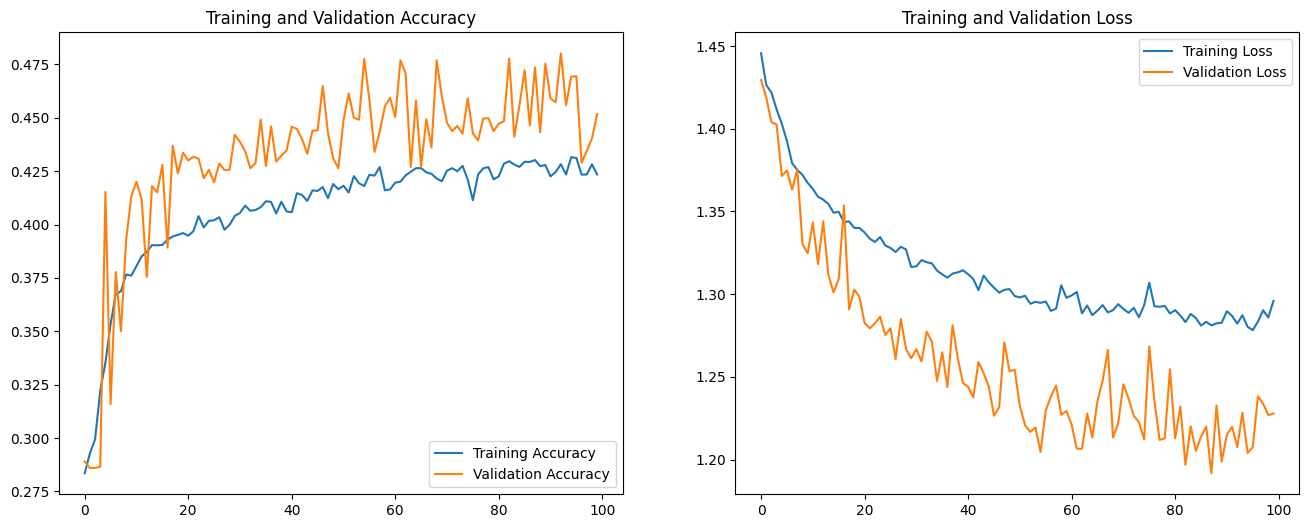

In [9]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

In [ ]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 38ms/step - loss: 1.3589 - accuracy: 0.3851 - val_loss: 1.2292 - val_accuracy: 0.4238
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2302 - accuracy: 0.4504 - val_loss: 1.1173 - val_accuracy: 0.4948
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1978 - accuracy: 0.4613 - val_loss: 1.1002 - val_accuracy: 0.5193
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 1.1796 - accuracy: 0.4729 - val_loss: 1.0817 - val_accuracy: 0.5182
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1681 - accuracy: 0.4787 - val_loss: 1.0942 - val_accuracy: 0.5052
Epoch 6/100
360/360 [==============================] - 13s 35ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 35ms/step - loss: 1.0684 - accuracy: 0.5357 - val_loss: 0.9696 - val_accuracy: 0.5830
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 1.0692 - accuracy: 0.5355 - val_loss: 0.9916 - val_accuracy: 0.5768
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0650 - accuracy: 0.5380 - val_loss: 1.0086 - val_accuracy: 0.5571
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0674 - accuracy: 0.5391 - val_loss: 0.9754 - val_accuracy: 0.5776
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0626 - accuracy: 0.5365 - val_loss: 0.9743 - val_accuracy: 0.5799
Epoch 61/100
360/360 [==============================] - 12s 35ms/step - loss: 1.0723 - accuracy: 0.5343 - val_loss: 0.9695 - val_accuracy: 0.5795
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0683 - accuracy: 0.5325 - val_loss: 0.9802 -

360/360 [==============================] - 12s 35ms/step - loss: 1.1890 - accuracy: 0.4706 - val_loss: 1.0899 - val_accuracy: 0.5085
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 1.1766 - accuracy: 0.4811 - val_loss: 1.0515 - val_accuracy: 0.5351
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1617 - accuracy: 0.4858 - val_loss: 1.0553 - val_accuracy: 0.5415
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1478 - accuracy: 0.4924 - val_loss: 1.0532 - val_accuracy: 0.5363
Epoch 7/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1413 - accuracy: 0.4946 - val_loss: 1.0708 - val_accuracy: 0.5380
Epoch 8/100
360/360 [==============================] - 13s 36ms/step - loss: 1.1360 - accuracy: 0.4945 - val_loss: 1.0659 - val_accuracy: 0.5455
Epoch 9/100
360/360 [==============================] - 13s 35ms/step - loss: 1.1319 - accuracy: 0.5038 - val_loss: 1.0535 - val_accuracy: 0.54

360/360 [==============================] - 12s 35ms/step - loss: 1.0814 - accuracy: 0.5287 - val_loss: 1.0450 - val_accuracy: 0.5384
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0854 - accuracy: 0.5299 - val_loss: 1.0018 - val_accuracy: 0.5691
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0778 - accuracy: 0.5348 - val_loss: 1.0049 - val_accuracy: 0.5629
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0809 - accuracy: 0.5337 - val_loss: 0.9858 - val_accuracy: 0.5672
Epoch 63/100
360/360 [==============================] - 12s 35ms/step - loss: 1.0807 - accuracy: 0.5339 - val_loss: 0.9965 - val_accuracy: 0.5683
Epoch 64/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0810 - accuracy: 0.5319 - val_loss: 1.0034 - val_accuracy: 0.5636
Epoch 65/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0830 - accuracy: 0.5311 - val_loss: 1.0190 - val_accuracy

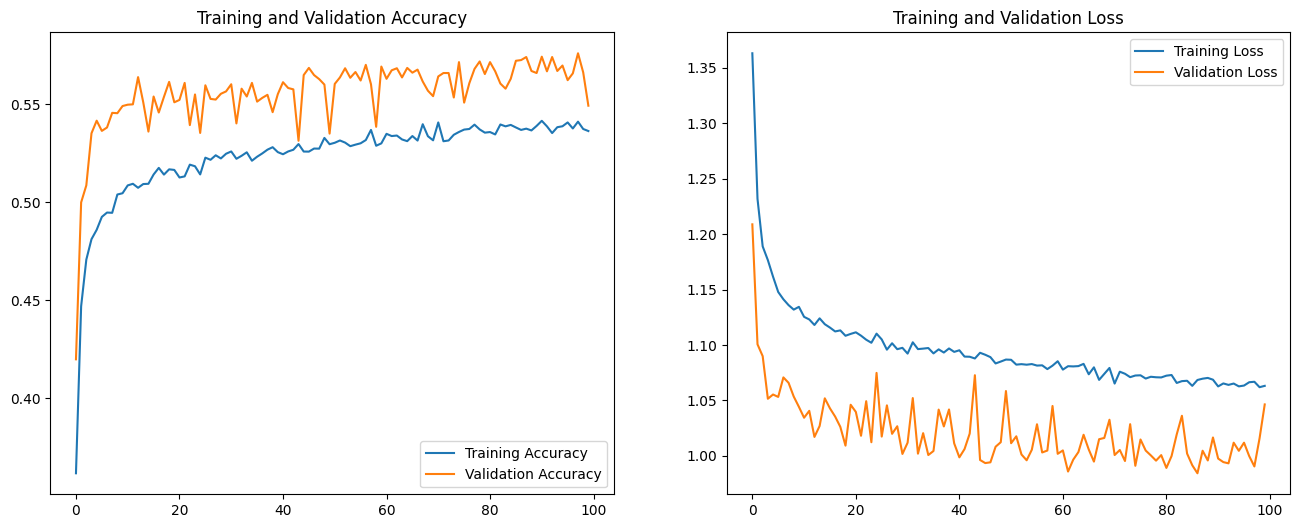

In [11]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 39ms/step - loss: 1.4545 - accuracy: 0.2820 - val_loss: 1.4133 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4274 - accuracy: 0.2864 - val_loss: 1.4164 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4251 - accuracy: 0.2854 - val_loss: 1.4116 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4236 - accuracy: 0.2886 - val_loss: 1.4133 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4227 - accuracy: 0.2863 - val_loss: 1.4125 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3136 - accuracy: 0.3819 - val_loss: 1.2508 - val_accuracy: 0.4585
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3086 - accuracy: 0.3855 - val_loss: 1.2278 - val_accuracy: 0.4818
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3007 - accuracy: 0.4002 - val_loss: 1.2460 - val_accuracy: 0.4698
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3163 - accuracy: 0.3809 - val_loss: 1.2436 - val_accuracy: 0.4649
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3168 - accuracy: 0.3780 - val_loss: 1.2489 - val_accuracy: 0.4679
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3117 - accuracy: 0.3895 - val_loss: 1.2331 - val_accuracy: 0.4575
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3077 - accuracy: 0.3894 - val_loss: 1.2353 -

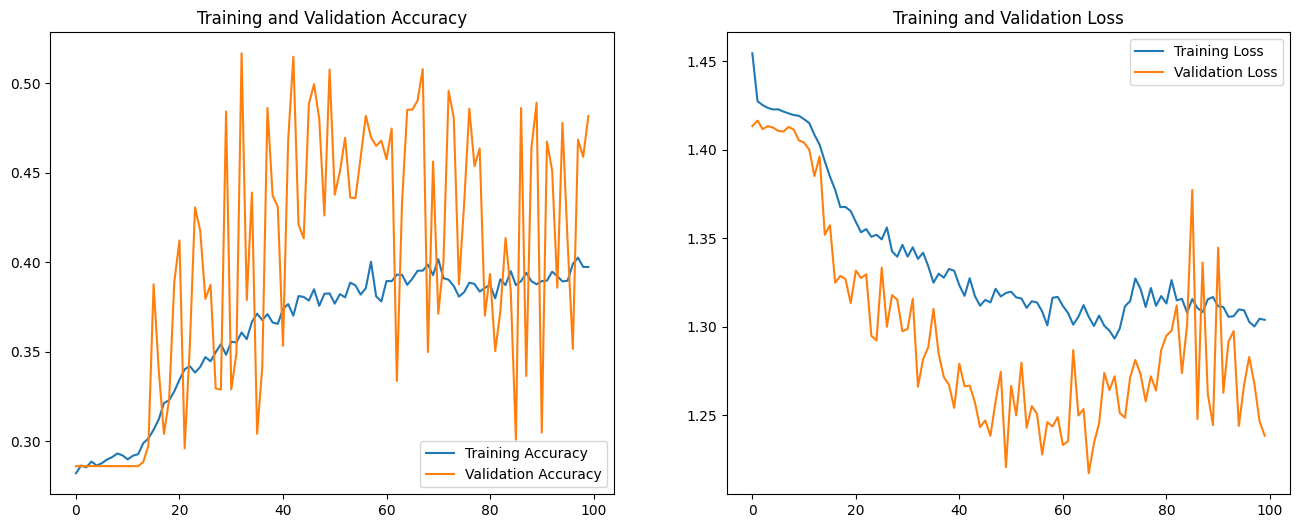

In [12]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 19s 38ms/step - loss: 1.4448 - accuracy: 0.2827 - val_loss: 1.4242 - val_accuracy: 0.2746
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4268 - accuracy: 0.2915 - val_loss: 1.4147 - val_accuracy: 0.2961
Epoch 3/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4254 - accuracy: 0.2953 - val_loss: 1.4162 - val_accuracy: 0.2746
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4242 - accuracy: 0.2883 - val_loss: 1.4119 - val_accuracy: 0.3024
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4238 - accuracy: 0.2909 - val_loss: 1.4229 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4218 - accuracy: 0.2

Epoch 56/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3298 - accuracy: 0.3863 - val_loss: 1.2852 - val_accuracy: 0.3930
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3328 - accuracy: 0.3869 - val_loss: 1.2876 - val_accuracy: 0.4147
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3332 - accuracy: 0.3774 - val_loss: 1.2765 - val_accuracy: 0.4189
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3298 - accuracy: 0.3881 - val_loss: 1.2876 - val_accuracy: 0.4146
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3317 - accuracy: 0.3823 - val_loss: 1.2943 - val_accuracy: 0.3937
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3306 - accuracy: 0.3878 - val_loss: 1.3061 - val_accuracy: 0.4166
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3263 - accuracy: 0.3874 - val_loss: 1.2958 -

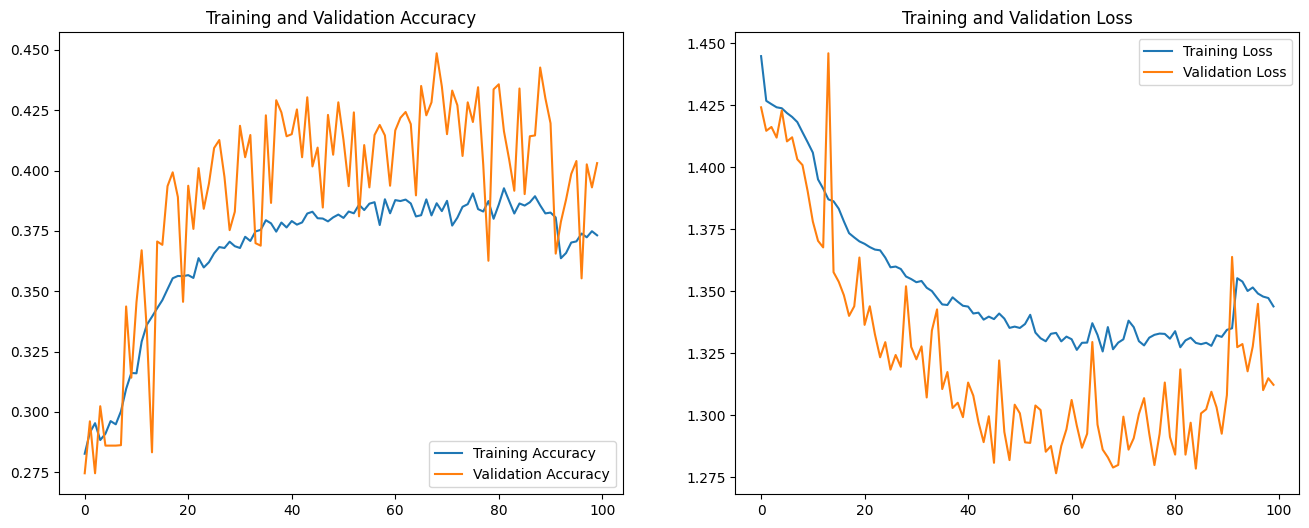

In [13]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 38ms/step - loss: 1.4558 - accuracy: 0.2850 - val_loss: 1.4116 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4277 - accuracy: 0.2932 - val_loss: 1.4180 - val_accuracy: 0.4248
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4211 - accuracy: 0.3017 - val_loss: 1.4122 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4127 - accuracy: 0.3192 - val_loss: 1.3795 - val_accuracy: 0.4137
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3936 - accuracy: 0.3445 - val_loss: 1.3709 - val_accuracy: 0.3442
Epoch 6/100
360/360 [==============================] - 13s 35ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2751 - accuracy: 0.4238 - val_loss: 1.2118 - val_accuracy: 0.4844
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2679 - accuracy: 0.4303 - val_loss: 1.1962 - val_accuracy: 0.4667
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2752 - accuracy: 0.4244 - val_loss: 1.1984 - val_accuracy: 0.4734
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2717 - accuracy: 0.4264 - val_loss: 1.2293 - val_accuracy: 0.4759
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2746 - accuracy: 0.4242 - val_loss: 1.2292 - val_accuracy: 0.4759
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2732 - accuracy: 0.4290 - val_loss: 1.2108 - val_accuracy: 0.4628
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2689 - accuracy: 0.4300 - val_loss: 1.2149 -

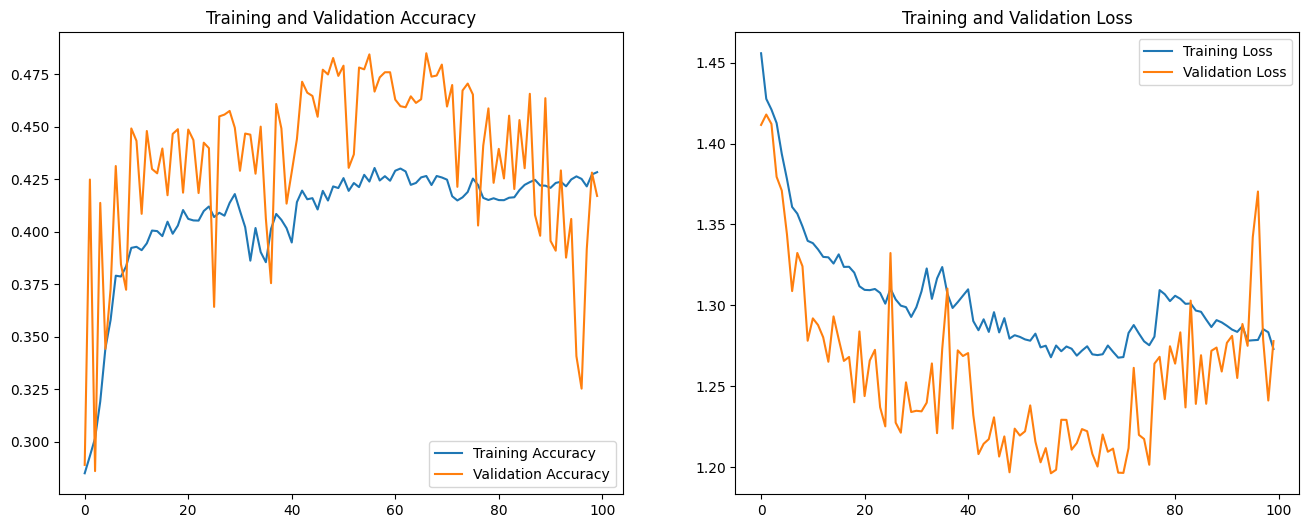

In [14]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 18s 38ms/step - loss: 1.4478 - accuracy: 0.2860 - val_loss: 1.4143 - val_accuracy: 0.2749
Epoch 2/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4242 - accuracy: 0.2999 - val_loss: 1.4048 - val_accuracy: 0.2746
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4161 - accuracy: 0.3108 - val_loss: 1.3861 - val_accuracy: 0.2972
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 1.4036 - accuracy: 0.3293 - val_loss: 1.3711 - val_accuracy: 0.3015
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3881 - accuracy: 0.3465 - val_loss: 1.3544 - val_accuracy: 0.3506
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 1.3766 - accuracy: 0.3

Epoch 56/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2917 - accuracy: 0.4163 - val_loss: 1.2257 - val_accuracy: 0.4750
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2915 - accuracy: 0.4193 - val_loss: 1.2581 - val_accuracy: 0.4526
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2922 - accuracy: 0.4132 - val_loss: 1.2240 - val_accuracy: 0.4746
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2934 - accuracy: 0.4151 - val_loss: 1.2742 - val_accuracy: 0.4066
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2911 - accuracy: 0.4167 - val_loss: 1.2172 - val_accuracy: 0.4668
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 1.2904 - accuracy: 0.4167 - val_loss: 1.2779 - val_accuracy: 0.4109
Epoch 62/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2956 - accuracy: 0.4171 - val_loss: 1.2486 -

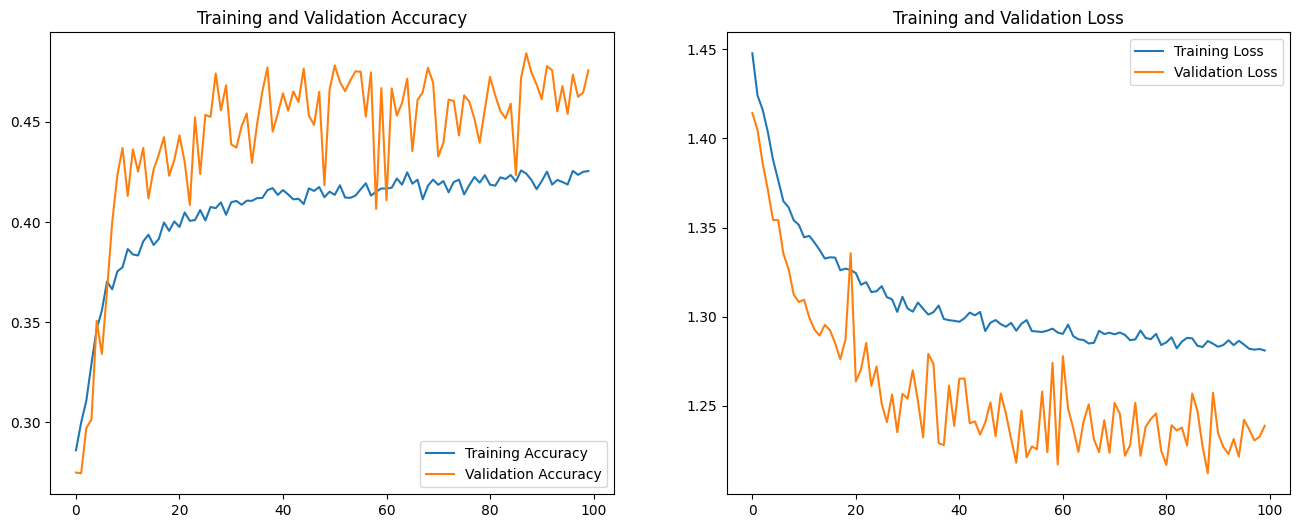

In [15]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [16]:
# !mkdir resnet50_nontrainable
# pd.DataFrame(res_rgb).to_csv("resnet50_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("resnet50_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("resnet50_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("resnet50_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("resnet50_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("resnet50_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("resnet50_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("resnet50_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("resnet50_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("resnet50_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("resnet50_nontrainable/res_ydbdr_nonpre.csv", index=False)